# **1. Matériel : vérifier que le GPU est bien sélectionné (A COMPLETER)**

In [1]:
!nvidia-smi

Sun Jan 15 19:13:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.48       Driver Version: 517.48       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   51C    P3    33W / 170W |    982MiB / 12288MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **2. Importation des librairies**

In [22]:
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2 
import csv
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input #224*224
from keras.applications.xception import Xception
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
import math
from PIL import Image
from google.colab import files
print("Tensorflow version: "+tf.__version__)
print("Keras version: " + tf.keras.__version__)

ModuleNotFoundError: No module named 'google.colab'

#**3. Téléchargement des données d'entrainement "Small Dataset"**

In [21]:
!rm -rf sample_data
!wget https://cluster.ig.umons.ac.be/HackIA21/databases/suspect_classification/Small_Suspect_Database.zip
!unzip Small_Suspect_Database.zip
!rm Small_Suspect_Database.zip

'rm' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!rm -rf sample_data
!wget https://cluster.ig.umons.ac.be/HackIA21/databases/suspect_classification/Big_Suspect_Database.zip
!unzip Big_Suspect_Database.zip
!rm Big_Suspect_Database.zip

#**5. Création du fichier de labels "classes.txt"**

In [21]:
!printf '%s\n' 'appareil_photo' 'arme' 'autres' 'baton' 'couteau' 'drone' 'gillet_jaune' 'grenade' 'personne'> classes.txt

#**6. Paramètres d'entrainement et sélection du modèle pré-entrainé**

In [22]:
nb_classes = 9
batch_size=32 #@param [1,2,4,8,16,32,64,128] {type:"raw"}
epochs=5 #@param [2, 5, 10,20,50,100,200] {type:"raw"}
dataset_name='Big_Suspect_Database' #@param ["Small_Suspect_Database","Big_Suspect_Database","Personal_Database"]
train_dataset = os.path.join(dataset_name, 'train/')
test_dataset = os.path.join(dataset_name, 'test/')
input_dim=224 #@param [224,299] {type:"raw"}  
classes_path = "classes.txt"
classifier = "MobileNet" #@param ["Xception","VGG16","VGG19","ResNet50","ResNet121","ResNet152","ResNet50V2","ResNet121V2","ResNet152V2","InceptionV3","InceptionResNetV2","MobileNet","MobileNetV2","DenseNet121","DenseNet169","DenseNet201","NASNetLarge","NASNetMobile"] {type:"string"}

# **7. Compter le nombre de classes**

In [23]:
# Récupérer les noms des classes
with open(classes_path, 'r') as f:
    classes = f.readlines()
    classes = list(map(lambda x: x.strip(), classes))
num_classes = len(classes)

# **8. Création du jeu de données d'entraînement  (A COMPLETER)**

In [24]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
	train_dataset,                     # chemin vers le jeu de données
	validation_split=0.2,              # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
	subset="training",                 # Sélection du jeu de données d'entraînement
	seed=42,                           # Initialisation du générateur aléatoire (permutations)
	image_size=(input_dim,input_dim),  # Taille des images d'entrée
	batch_size=batch_size,         # Taille du mini-batch
  label_mode='categorical'          # Conversion au format One-Hot
)

Found 845 files belonging to 9 classes.
Using 676 files for training.


#**9. Créer le jeu de validation (A COMPLETER : même générateur, One-Hot, jeu "validation")**

In [25]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
	train_dataset,                     # chemin vers le jeu de données
	validation_split=0.2,              # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
	subset="validation",               # Sélection du jeu de données d'entraînement
	seed=42,                           # Initialisation du générateur aléatoire (permutations)
	image_size=(input_dim,input_dim),  # Taille des images d'entrée
	batch_size=batch_size,             # Taille du mini-batch
  label_mode='categorical'           # Conversion au format One-Hot
)

Found 845 files belonging to 9 classes.
Using 169 files for validation.


# **10. Télécharger un modèle préentraîné et appliquer le Transfer Learning**



In [26]:
from keras.applications.mobilenet import MobileNet
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(input_dim,input_dim,3))
# create a custom top classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.inputs, outputs=predictions)

# **11. Geler puis dégeler les poids des premières couches**

In [27]:
#freeze layers
for layer in base_model.layers:
    layer.trainable = False

# **11. Compiler le modèle avec la descente de gradient stochastique DSG**


In [28]:
# recompiler le modèle
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

# **12. Entraîner le modèle**

In [ ]:
history=model.fit(
    train_ds,
    steps_per_epoch=math.ceil(len(train_ds)),
    epochs=epochs,
    validation_data=val_ds,
    validation_steps=math.ceil(len(val_ds)),
    verbose=1
)

#**13. Sauvegarder le modèle final (A COMPLETER)**


In [30]:
model.save("result.h5")

#**14. Afficher des courbes d'entrainement/validation**

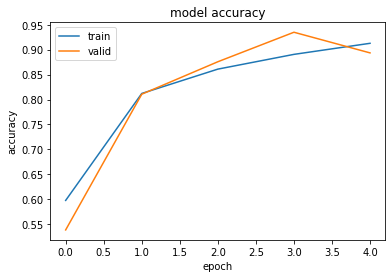

In [31]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# **15. Créer le jeu de données de test**

In [32]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
	test_dataset,               # chemin vers le jeu de données
	seed=42,                    # Initialisation du générateur aléatoire (permutations)
	image_size=(224,224),       # Taille des images d'entrée
	batch_size=batch_size,      # Taille du mini-batch
  label_mode='categorical'    # Conversion au format One-Hot
)

Found 200 files belonging to 9 classes.


# **16. Evaluer le modèle avec ce jeu de données de test**

In [33]:
score = model.evaluate(test_ds,  steps=len(test_ds),workers = 1)
print("%s: %.2f%%" % (model.metrics_names[0], score[0]))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

7/7 [==============================] - 2s 79ms/step - loss: 2.9440 - accuracy: 0.3000
loss: 2.94%
accuracy: 30.00%


#**16. Tester le modèle avec une image de test: "fire.jpg" et "no_fire.jpg (A COMPLETER)"**

Big_Suspect_Database/test/appareil_photo/1.jpg
1/1 [==============================] - 0s 370ms/step
Class Name : appareil_photo --- Class Probability: 93.68%
Big_Suspect_Database/test/appareil_photo/48.jpg
1/1 [==============================] - 0s 18ms/step
Class Name : autre --- Class Probability: 67.64%
Big_Suspect_Database/test/arme/239.jpg
1/1 [==============================] - 0s 20ms/step
Class Name : autre --- Class Probability: 45.00%
Big_Suspect_Database/test/couteau/555.jpg
1/1 [==============================] - 0s 18ms/step
Class Name : couteau --- Class Probability: 33.95%
Big_Suspect_Database/test/autre/424.jpg
1/1 [==============================] - 0s 21ms/step
Class Name : appareil_photo --- Class Probability: 38.03%
Big_Suspect_Database/test/baton/483.jpg
1/1 [==============================] - 0s 18ms/step
Class Name : baton --- Class Probability: 70.68%
Big_Suspect_Database/test/drone/840.jpg
1/1 [==============================] - 0s 18ms/step
Class Name : autre --- Cl

<Figure size 432x288 with 0 Axes>

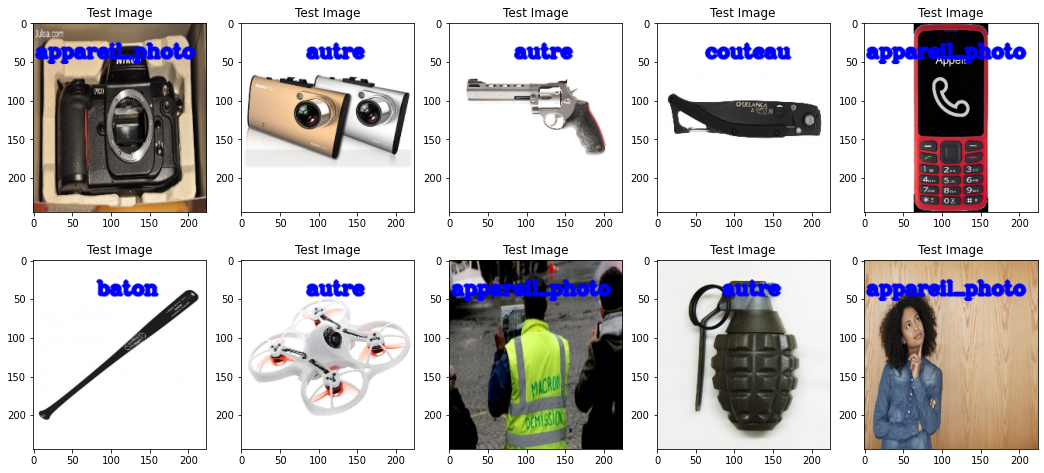

In [34]:
classes = train_ds.class_names
images_to_test = ["Big_Suspect_Database/test/appareil_photo/1.jpg",
                  "Big_Suspect_Database/test/appareil_photo/48.jpg",
                  "Big_Suspect_Database/test/arme/239.jpg",
                  "Big_Suspect_Database/test/couteau/555.jpg",
                  "Big_Suspect_Database/test/autre/424.jpg",
                  "Big_Suspect_Database/test/baton/483.jpg",
                  "Big_Suspect_Database/test/drone/840.jpg",
                  "Big_Suspect_Database/test/gilet_jaune/1110.jpg",
                  "Big_Suspect_Database/test/grenade/1262.jpg",
                  "Big_Suspect_Database/test/personne/1391.jpg",
]

axes=[]
fig=plt.figure()
fig = plt.figure(figsize=(18,8))
i=0
for image_path in images_to_test:
    i+=1
    print(image_path)
    img = Image.open(image_path).convert('RGB')
    x = tf.keras.utils.img_to_array(img,data_format='channels_last')
    x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
    x = np.expand_dims(x, axis=0)
    pred = model.predict(x,batch_size=64)[0]
    for (pos,prob) in enumerate(pred):
      class_name = classes[pos]
      if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,244))
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 6
        cv2.putText(img, class_name, (int(textX)+20, int(textY)), font, 0.8, (0,0,255), 4, cv2.LINE_AA)
        axes.append(fig.add_subplot(2, 5, i) )
        axes[-1].set_title("Test Image")  
        plt.imshow(img)
        print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()